In [ ]:
# uncomment and run this block to install all necessary Julia packages

# using Pkg

# Pkg.add("ProgressMeter")
# Pkg.add("Distributions")
# Pkg.add("StatsPlots")
# Pkg.add("Statistics")
# Pkg.add("Random")

In [107]:
using Plots, Statistics, Distributions, Random, ProgressMeter

In [108]:
# helper functions for the BEAM algorithm

function generate_midpoints(n_bins)
    quantiles = Array{Float64}(undef, n_bins)
    quantile_midpoints = Array{Float64}(undef, n_bins)

    #generate the quantile midpoints
    for i = 1:n_bins
        quantiles[i] = i/n_bins
        quantile_midpoints[i] = i/n_bins - (1/2)*(1/n_bins)
    end

    return vec(quantiles), vec(quantile_midpoints)
end

function add_distributions(list1, list2)
    sum_list = Array{Float64}(undef, length(list1)^2)
    
    list1 = repeat(list1, length(list1))
    list1 = sort(list1)
    list2 = repeat(list2, length(list2))
    
    for i in eachindex(sum_list)
        sum_list[i] = list1[i] + list2[i]
    end
    
    return vec(sort(sum_list))
end

function multiply_distributions(list1, list2)
    sum_list = Array{Float64}(undef, length(list1)^2)
    
    list1 = repeat(list1, length(list1))
    list1 = sort(list1)
    list2 = repeat(list2, length(list2))
    
    for i in eachindex(sum_list)
        sum_list[i] = list1[i] * list2[i]
    end
    
    return vec(sort(sum_list))
end

function re_bin(distribution, n_bins)
    rebinned = reshape(distribution, n_bins, n_bins)
    rebinned = mean(rebinned, dims = 1)
    
    return vec(rebinned)
end

function calculate_mean(RV, n_bins)
    return sum(RV .* 1/n_bins)
end

function calculate_variance(RV, calculated_mean, n_bins)
    return sum(RV.^2 * (1/n_bins)) - calculated_mean^2
end

function multiplicative_true_mean(μ, n_RVs)
    # this function assumes that all RVs are i.i.d.
    #    recommend editing for modularity later
    return μ^n_RVs
end

function multiplicative_true_variance(μ, σ, n_RVs)
    # this function assumes that all RVs are i.i.d.
    #    recommend editing for modularity later
    variance = 1
    mean_prod_square = true_mean(μ^2, n_RVs)
    
    for i = 1:n_RVs
        # compute the second moment of the product distribution
        variance = variance * (σ^2 + μ^2)
    end
    
    # compute the second central moment
    variance = variance - mean_prod_square
    return variance
end

function BEAM(RV_list::Array, n_bins::Number, multiplication::Bool)
    n_RVs = length(RV_list)
    
    # define the list of quantiles and quantile midpoints
    quantiles, quantile_midpoints = generate_midpoints(n_bins)
    
    final_RV = first(RV_list)
    final_RV = quantile.(final_RV, quantile_midpoints)

    for i = 2:length(RV_list)
        temp_list = quantile.(RV_list[i], quantile_midpoints)
        if multiplication
            final_RV = multiply_distributions(temp_list, final_RV)
        else
            final_RV = add_distributions(temp_list, final_RV)
        end
        final_RV = re_bin(final_RV, n_bins) 
    end

    return final_RV
end

BEAM (generic function with 1 method)

In [120]:
# helper functions for the Monte-Carlo simulation
function cumulative_average(list::Array)
    cumulative_averages = Array{Float64}(undef, length(list))
    cumulative_averages[1] = list[1]
    
    for i in 2:length(list)
        cumulative_averages[i] = mean(list[1:(i-1)])
    end
    
    return cumulative_averages
end

function cumulative_stddev(list::Array, Corrected::Bool)
    cumulative_stddevs = Array{Float64}(undef, length(list))
    cumulative_stddevs[1] = 0
    
    for i in 2:length(list)
        cumulative_stddevs[i] = std(list[1:(i-1)], corrected = Corrected)
    end
    
    return cumulative_stddevs
end

function cumulative_var(list::Array, Corrected::Bool)
    cumulative_var = Array{Float64}(undef, length(list))
    cumulative_var[1] = 0
    
    for i in 2:length(list)
        cumulative_var[i] = var(list[1:(i-1)], corrected = Corrected)
    end
    
    return cumulative_var
end


function montecarlo(RV_list::Array, n_reps::Number, multiplication::Bool)
    n_RVs = length(RV_list)
    
    output = Array{Float64}(undef, n_reps)
    
    for i = 1:n_reps
        random_draws = map(x -> rand(x), RV_list)
        if multiplication
            output[i] = prod(random_draws)
        else
            output[i] = sum(random_draws)
        end
    end
    
    return output
end

montecarlo (generic function with 1 method)

In [110]:
# helper functions for computing error vectors for both methods

function compute_variance_error(BEAM_variances::Array, montecarlo_variances::Array, true_variance::Number)
    BEAM_errors = BEAM_variances .- true_variance
    montecarlo_errors = montecarlo_variances .- true_variance
    
    return BEAM_errors, montecarlo_errors
end

function compute_averages_error(BEAM_means::Array, montecarlo_means::Array, true_mean::Number)
    BEAM_errors = BEAM_means .- true_mean
    montecarlo_errors = montecarlo_means .- true_mean
    
    return BEAM_errors, montecarlo_errors
end

compute_averages_error (generic function with 1 method)

In [121]:
# main code, edit these values for different comparisons between the BEAM/Monte Carlo methods:

n_replications = 100
n_RVs = 30
multiplication = false

μ = 6
σ = 3

# Theoretical mean and variance by the convolution of iid normal RVs
true_mu = n_RVs * μ
true_var = n_RVs * σ^2
# true_mu = multiplicative_true_mean(μ, n_RVs)
# true_var = multiplicative_true_variance(μ, σ, n_RVs)


# minimum number of bins = 4
BEAM_convolution = Array{Float64}(undef, n_replications - 3)
BEAM_variances = Array{Float64}(undef, n_replications - 3)

# instantiate a list of iid RVs to avoid creating them in memory for each BEAM loop
RV_list = Array{Distribution}(undef, n_RVs)
RV_list = [Normal(μ, σ) for i = 1:n_RVs]

# loop through BEAM process with an increasing number of bins from 4 - n_replications
@showprogress "Computing BEAM convolutions" for i = 4:n_replications
    RV = BEAM(RV_list, i, multiplication)
    BEAM_convolution[i - 3] = calculate_mean(RV, i)
    BEAM_variances[i - 3] = calculate_variance(RV, BEAM_convolution[i - 3], i)
end

# generate Monte Carlo results
Corrected = false
montecarlo_convolutions = montecarlo(RV_list, n_replications, multiplication)
montecarlo_convolutions = cumulative_average(montecarlo_convolutions)
montecarlo_variances = cumulative_var(montecarlo_convolutions, Corrected)

# compute error vectors
BEAM_var_error, montecarlo_var_error = compute_variance_error(BEAM_variances, 
                                                              montecarlo_variances, 
                                                              true_var);
BEAM_mean_error, montecarlo_mean_error = compute_averages_error(BEAM_convolution, 
                                                                montecarlo_convolutions, 
                                                                true_mu);

Computing BEAM convolutions100%|████████████████████████| Time: 0:00:00


In [122]:
#shifting the BEAM vectors since the minimum number of bins is 4
BEAM_var_error = vcat([NaN, NaN, NaN], BEAM_var_error)
BEAM_mean_error = vcat([NaN, NaN, NaN], BEAM_mean_error);

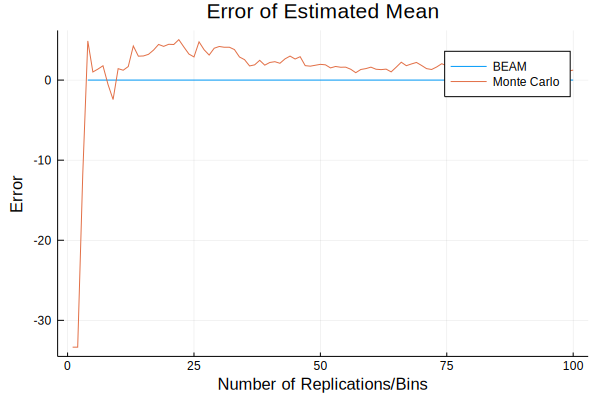

In [123]:
plot(BEAM_mean_error, title = "Error of Estimated Mean", label = "BEAM")
plot!(montecarlo_mean_error, label = "Monte Carlo")
plot!(xlab = "Number of Replications/Bins", ylab = "Error")

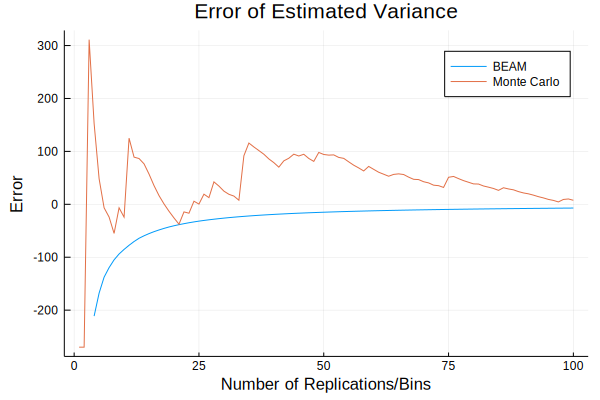

In [114]:
plot(BEAM_var_error, title = "Error of Estimated Variance", label = "BEAM")
plot!(montecarlo_var_error, label = "Monte Carlo")
plot!(xlab = "Number of Replications/Bins", ylab = "Error")

In [115]:
empirical_mean_BEAM = last(BEAM_convolution)
empirical_variance_BEAM = last(BEAM_variances)

empirical_mean_montecarlo = last(montecarlo_convolutions)
empirical_variance_montecarlo = last(montecarlo_variances)

# true_mu = multiplicative_true_mean(μ, n_RVs)
# true_var = multiplicative_true_variance(μ, σ, n_RVs)

println("Theoretical Mean is: ", true_mu)
println("Calculated BEAM Mean is: ", empirical_mean_BEAM)
println("Calculated Monte Carlo Mean is: ", empirical_mean_montecarlo)

println("Theoretical Variance is: ", true_var)
println("Calculated BEAM Variance is: ", empirical_variance_BEAM)
println("Calculated Monte Carlo Variance is: ", empirical_variance_montecarlo)

Theoretical Mean is: 180
Calculated BEAM Mean is: 180.0
Calculated Monte Carlo Mean is: 179.89031739937832
Theoretical Variance is: 270
Calculated BEAM Variance is: 262.92299286497655
Calculated Monte Carlo Variance is: 277.6050574377143


In [124]:
# main code, edit these values for different comparisons between the BEAM/Monte Carlo methods:

n_replications = 100
n_RVs = 30
multiplication = false

RV_list = Array{Distribution}(undef, n_RVs)

# for non-iid normals, create a list of μ and σ values and instantiate the distributions separately
μ_list = rand(5:10, n_RVs)
σ_list = rand(1:6, n_RVs)

# instantiate a list of RVs to avoid creating them in memory for each BEAM loop
RV_list = [Normal(μ_list[i], σ_list[i]) for i = 1:n_RVs]

# Theoretical mean and variance by the convolution of iid normal RVs
true_mu = sum(μ_list)
true_var = sum(σ_list.^2)

# true_mu = multiplicative_true_mean(μ, n_RVs)
# true_var = multiplicative_true_variance(μ, σ, n_RVs)


# minimum number of bins = 4
BEAM_convolution = Array{Float64}(undef, n_replications - 3)
BEAM_variances = Array{Float64}(undef, n_replications - 3)


# loop through BEAM process with an increasing number of bins from 4 - n_replications
@showprogress "Computing BEAM convolutions" for i = 4:n_replications
    RV = BEAM(RV_list, i, multiplication)
    BEAM_convolution[i - 3] = calculate_mean(RV, i)
    BEAM_variances[i - 3] = calculate_variance(RV, BEAM_convolution[i - 3], i)
end

# generate Monte Carlo results
Corrected = false
montecarlo_convolutions = montecarlo(RV_list, n_replications, multiplication)
montecarlo_convolutions = cumulative_average(montecarlo_convolutions)
montecarlo_variances = cumulative_var(montecarlo_convolutions, Corrected)

# compute error vectors
BEAM_var_error, montecarlo_var_error = compute_variance_error(BEAM_variances, 
                                                              montecarlo_variances, 
                                                              true_var);
BEAM_mean_error, montecarlo_mean_error = compute_averages_error(BEAM_convolution, 
                                                                montecarlo_convolutions, 
                                                                true_mu);

Computing BEAM convolutions100%|████████████████████████| Time: 0:00:00


In [125]:
#shifting the BEAM vectors since the minimum number of bins is 4
BEAM_var_error = vcat([NaN, NaN, NaN], BEAM_var_error)
BEAM_mean_error = vcat([NaN, NaN, NaN], BEAM_mean_error);

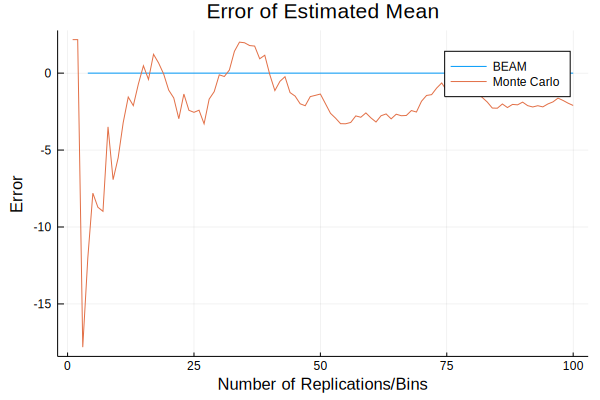

In [126]:
plot(BEAM_mean_error, title = "Error of Estimated Mean", label = "BEAM")
plot!(montecarlo_mean_error, label = "Monte Carlo")
plot!(xlab = "Number of Replications/Bins", ylab = "Error")

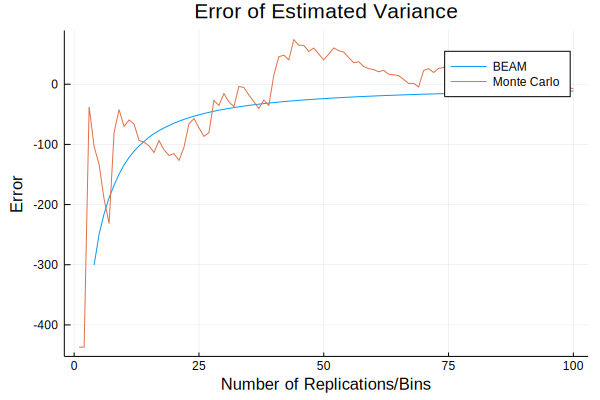

In [127]:
plot(BEAM_var_error, title = "Error of Estimated Variance", label = "BEAM")
plot!(montecarlo_var_error, label = "Monte Carlo")
plot!(xlab = "Number of Replications/Bins", ylab = "Error")

In [128]:
empirical_mean_BEAM = last(BEAM_convolution)
empirical_variance_BEAM = last(BEAM_variances)

empirical_mean_montecarlo = last(montecarlo_convolutions)
empirical_variance_montecarlo = last(montecarlo_variances)

# true_mu = multiplicative_true_mean(μ, n_RVs)
# true_var = multiplicative_true_variance(μ, σ, n_RVs)

println("Theoretical Mean is: ", true_mu)
println("Calculated BEAM Mean is: ", empirical_mean_BEAM)
println("Calculated Monte Carlo Mean is: ", empirical_mean_montecarlo)

println("Theoretical Variance is: ", true_var)
println("Calculated BEAM Variance is: ", empirical_variance_BEAM)
println("Calculated Monte Carlo Variance is: ", empirical_variance_montecarlo)

Theoretical Mean is: 230
Calculated BEAM Mean is: 230.00000000000003
Calculated Monte Carlo Mean is: 227.89839213617813
Theoretical Variance is: 437
Calculated BEAM Variance is: 425.70765637278237
Calculated Monte Carlo Variance is: 429.3864323844795


In [134]:
# main code, edit these values for different comparisons between the BEAM/Monte Carlo methods:

# Gamma distribution with parameters α and θ. 
# Mean = α*θ
# Variance = α*θ^2

n_replications = 100
n_RVs = 30
multiplication = false

α = 4
θ = 0.5

RV_list = Array{Distribution}(undef, n_RVs)

# instantiate a list of RVs to avoid creating them in memory for each BEAM loop
RV_list = [Gamma(α, θ) for i = 1:n_RVs]

# Theoretical mean and variance by the convolution of iid normal RVs
true_mu = n_RVs * α * θ
true_var = n_RVs * α * θ^2

# true_mu = multiplicative_true_mean(μ, n_RVs)
# true_var = multiplicative_true_variance(μ, σ, n_RVs)


# minimum number of bins = 4
BEAM_convolution = Array{Float64}(undef, n_replications - 3)
BEAM_variances = Array{Float64}(undef, n_replications - 3)


# loop through BEAM process with an increasing number of bins from 4 - n_replications
@showprogress "Computing BEAM convolutions" for i = 4:n_replications
    RV = BEAM(RV_list, i, multiplication)
    BEAM_convolution[i - 3] = calculate_mean(RV, i)
    BEAM_variances[i - 3] = calculate_variance(RV, BEAM_convolution[i - 3], i)
end

# generate Monte Carlo results
Corrected = false
montecarlo_convolutions = montecarlo(RV_list, n_replications, multiplication)
montecarlo_convolutions = cumulative_average(montecarlo_convolutions)
montecarlo_variances = cumulative_var(montecarlo_convolutions, Corrected)

# compute error vectors
BEAM_var_error, montecarlo_var_error = compute_variance_error(BEAM_variances, 
                                                              montecarlo_variances, 
                                                              true_var);
BEAM_mean_error, montecarlo_mean_error = compute_averages_error(BEAM_convolution, 
                                                                montecarlo_convolutions, 
                                                                true_mu);

Computing BEAM convolutions100%|████████████████████████| Time: 0:00:00


In [135]:
#shifting the BEAM vectors since the minimum number of bins is 4
BEAM_var_error = vcat([NaN, NaN, NaN], BEAM_var_error)
BEAM_mean_error = vcat([NaN, NaN, NaN], BEAM_mean_error);

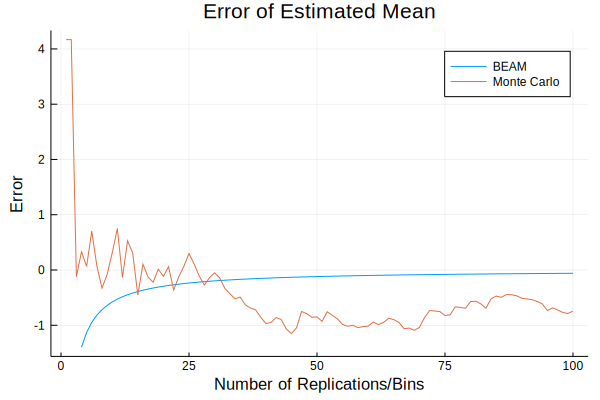

In [136]:
plot(BEAM_mean_error, title = "Error of Estimated Mean", label = "BEAM")
plot!(montecarlo_mean_error, label = "Monte Carlo")
plot!(xlab = "Number of Replications/Bins", ylab = "Error")

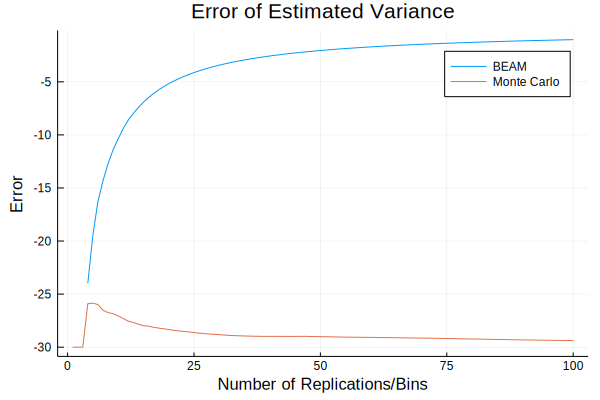

In [137]:
plot(BEAM_var_error, title = "Error of Estimated Variance", label = "BEAM")
plot!(montecarlo_var_error, label = "Monte Carlo")
plot!(xlab = "Number of Replications/Bins", ylab = "Error")

In [138]:
empirical_mean_BEAM = last(BEAM_convolution)
empirical_variance_BEAM = last(BEAM_variances)

empirical_mean_montecarlo = last(montecarlo_convolutions)
empirical_variance_montecarlo = last(montecarlo_variances)

# true_mu = multiplicative_true_mean(μ, n_RVs)
# true_var = multiplicative_true_variance(μ, σ, n_RVs)

println("Theoretical Mean is: ", true_mu)
println("Calculated BEAM Mean is: ", empirical_mean_BEAM)
println("Calculated Monte Carlo Mean is: ", empirical_mean_montecarlo)

println("Theoretical Variance is: ", true_var)
println("Calculated BEAM Variance is: ", empirical_variance_BEAM)
println("Calculated Monte Carlo Variance is: ", empirical_variance_montecarlo)

Theoretical Mean is: 60.0
Calculated BEAM Mean is: 59.94027107500876
Calculated Monte Carlo Mean is: 59.257439057349984
Theoretical Variance is: 30.0
Calculated BEAM Variance is: 28.97344994038349
Calculated Monte Carlo Variance is: 0.6236442224548092
